# **Spanish English Translation using LSTM**

Data Source : http://www.manythings.org/anki/

Parallel sentences : 50000

# **Importing Necessory Libraries**

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# **Loading Data file(s)**

In [ ]:
from google.colab import files 
  
  
uploaded = files.upload()

Saving hin.txt to hin.txt


In [ ]:
import io 
df=pd.read_csv('hin.txt', sep='\t' , header= None)
df.head()

,0,1,2
0,Wow!,वाह!,CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #6179147 (fastrizwaan)
1,Help!,बचाओ!,CC-BY 2.0 (France) Attribution: tatoeba.org #435084 (lukaszpp) & #459377 (minshirui)
2,Jump.,उछलो.,CC-BY 2.0 (France) Attribution: tatoeba.org #631038 (Shishir) & #6179121 (fastrizwaan)
3,Jump.,कूदो.,CC-BY 2.0 (France) Attribution: tatoeba.org #631038 (Shishir) & #6179122 (fastrizwaan)
4,Jump.,छलांग.,CC-BY 2.0 (France) Attribution: tatoeba.org #631038 (Shishir) & #6179123 (fastrizwaan)


In [ ]:
df=df[[0 , 1]]

In [ ]:
df.head()

,0,1
0,Wow!,वाह!
1,Help!,बचाओ!
2,Jump.,उछलो.
3,Jump.,कूदो.
4,Jump.,छलांग.


In [ ]:
len(df)

2923

# **Spliting Text to Sentences**

In [ ]:
# split using '\n' or newline character
sentences = text.strip().split('\n')
    
# split between english and spanish
spanish_english = [i.split('\t')[:2] for i in sentences]

# list to numpy array
spanish_english = np.array(spanish_english)

## Parallel data

In [ ]:
eng_hin = np.array(df)

In [ ]:
eng_hin.shape

(2923, 2)

# **Data Cleaning**

In [ ]:
# function to clean punctuations from text
def clean(sentence):
  punc = '''!()-[]{};:'", <>./?@#$%^&*_~'''
  for i in range(len(sentence)):  
        if sentence[i] in punc:  
            sentence =sentence.replace(sentence[i], " ")  
  return sentence

In [ ]:
for i in range(len(eng_hin)):
  eng_hin[i,0]=clean(eng_hin[i,0])
  eng_hin[i,1]=clean(eng_hin[i,1])

# **Data Transform**

In [ ]:
# transforming all uppercase character to lowercase to remove case sensitivity
for i in range(len(eng_hin)):
    eng_hin[i,0] = eng_hin[i,0].lower()
    eng_hin[i,1] = eng_hin[i,1].lower()

# **Tokenization**

In [ ]:
# for English side data
# initialising tokenizer
eng_tokenizer = Tokenizer()
# fitting data
eng_tokenizer.fit_on_texts(eng_hin[:,0])
# getting vocab size
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

# for English side data
# initialising tokenizer
hin_tokenizer = Tokenizer()
# fitting data
hin_tokenizer.fit_on_texts(eng_hin[:,1])
# getting vocab size
hin_vocab_size = len(hin_tokenizer.word_index) + 1

hin_length = 8
print('Hindi Vocabulary Size: %d' % hin_vocab_size)

English Vocabulary Size: 2387
Hindi Vocabulary Size: 3054


# **Splitting data into Train and Test Sets**

In [ ]:
from sklearn.model_selection import train_test_split

# split data into train and test set in 80:20 ratio
train, test = train_test_split(eng_hin, test_size=0.2, random_state = 12)

# **Tokens to Sequences**

In [ ]:
# function to encode text into numbers
def encode_sequences( tokenizer , length , lines):

  seq = tokenizer.texts_to_sequences(lines)
  
  # pad sequences with 0 values to make all sequences of equal length
  seq = pad_sequences(seq, maxlen=length, padding='post')

  return seq

In [ ]:
# prepare training data
# spanish part
trainX = encode_sequences(hin_tokenizer, hin_length, train[:, 1])

# english part
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
# spanish part
testX = encode_sequences(hin_tokenizer, hin_length, test[:, 1])

# english part
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

# **Modelling**

## **Defining Model** 

In [ ]:
# model initialisation
model = Sequential()

# adding embedding layer
model.add(Embedding(hin_vocab_size, 256, input_length=hin_length, mask_zero=True))

# adding a LSTM layer
model.add(LSTM(256))

model.add(RepeatVector(eng_length))

# adding a LSTM layer
model.add(LSTM(256, return_sequences=True))

# adding a dense layer to predict words in english
model.add(Dense(eng_vocab_size, activation='softmax'))

# view model details
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 8, 256)            781824    
_________________________________________________________________
lstm (LSTM)                  (None, 256)               525312    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 8, 256)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 8, 256)            525312    
_________________________________________________________________
dense (Dense)                (None, 8, 2387)           613459    
Total params: 2,445,907
Trainable params: 2,445,907
Non-trainable params: 0
_________________________________________________________________


## **Compiling model**

In [ ]:
# using adam optimizer with sparse categorical cross entropy as loss function
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

## **Training model**

In [ ]:
# path to save model
filename = 'drive/My Drive/en-hin-model'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=100, validation_split = 0.2,callbacks=[checkpoint], verbose=1)

Epoch 1/30
19/19 [==============================] - 12s 364ms/step - loss: 7.5265 - val_loss: 5.5157

Epoch 00001: val_loss improved from inf to 5.51570, saving model to drive/My Drive/en-hin-model


Epoch 2/30
19/19 [==============================] - 5s 270ms/step - loss: 5.3725 - val_loss: 5.3017

Epoch 00002: val_loss improved from 5.51570 to 5.30166, saving model to drive/My Drive/en-hin-model


Epoch 3/30
19/19 [==============================] - 5s 268ms/step - loss: 5.1207 - val_loss: 5.1672

Epoch 00003: val_loss improved from 5.30166 to 5.16715, saving model to drive/My Drive/en-hin-model


Epoch 4/30
19/19 [==============================] - 5s 266ms/step - loss: 4.9813 - val_loss: 5.0911

Epoch 00004: val_loss improved from 5.16715 to 5.09106, saving model to drive/My Drive/en-hin-model


Epoch 5/30
19/19 [==============================] - 5s 268ms/step - loss: 4.8396 - val_loss: 5.0155

Epoch 00005: val_loss improved from 5.09106 to 5.01551, saving model to drive/My Drive/en-hin-model


Epoch 6/30
19/19 [==============================] - 5s 277ms/step - loss: 4.7785 - val_loss: 4.9772

Epoch 00006: val_loss improved from 5.01551 to 4.97720, saving model to drive/My Drive/en-hin-model


Epoch 7/30
19/19 [==============================] - 5s 274ms/step - loss: 4.6771 - val_loss: 4.9425

Epoch 00007: val_loss improved from 4.97720 to 4.94253, saving model to drive/My Drive/en-hin-model


Epoch 8/30
19/19 [==============================] - 6s 304ms/step - loss: 4.6025 - val_loss: 4.9262

Epoch 00008: val_loss improved from 4.94253 to 4.92616, saving model to drive/My Drive/en-hin-model


Epoch 9/30
19/19 [==============================] - 5s 271ms/step - loss: 4.6151 - val_loss: 4.9190

Epoch 00009: val_loss improved from 4.92616 to 4.91897, saving model to drive/My Drive/en-hin-model


Epoch 10/30
19/19 [==============================] - 5s 267ms/step - loss: 4.5397 - val_loss: 4.9442

Epoch 00010: val_loss did not improve from 4.91897
Epoch 11/30
19/19 [==============================] - 6s 306ms/step - loss: 4.4841 - val_loss: 4.9409

Epoch 00011: val_loss did not improve from 4.91897
Epoch 12/30
19/19 [==============================] - 5s 267ms/step - loss: 4.4959 - val_loss: 4.9548

Epoch 00012: val_loss did not improve from 4.91897
Epoch 13/30
19/19 [==============================] - 5s 264ms/step - loss: 4.4652 - val_loss: 4.9631

Epoch 00013: val_loss did not improve from 4.91897
Epoch 14/30
19/19 [==============================] - 5s 268ms/step - loss: 4.3720 - val_loss: 4.9895

Epoch 00014: val_loss did not improve from 4.91897
Epoch 15/30
19/19 [==============================] - 5s 265ms/step - loss: 4.3974 - val_loss: 5.0244

Epoch 00015: val_loss did not improve from 4.91897
Epoch 16/30
19/19 [==============================] - 5s 268ms/step - loss: 4.3804 

## **Training performance**

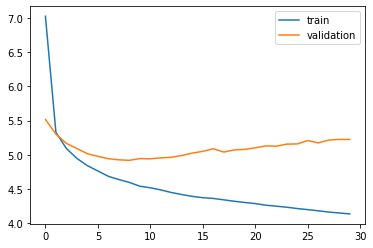

In [ ]:
# viewing model training progress 

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

# **Prediction on Test data**

In [ ]:
# load trained model
model = load_model('drive/My Drive/en-hin-model')

# list to store predictions
preds_list=[]

# predicting for 500 test sentences
for i in range(500):
  # predict function return the probabilities for target vobabularies
  # argmax return the index having the maximum value
  preds_list.append(np.argmax(model.predict(testX[i]), axis=-1))

## **Decoding predictions**

In [ ]:
# function to map numbers to word in english language
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [ ]:
# to store predicted texts
preds_text = []

# to traverse predicted values
for preds in preds_list:

  # to store predicted sentence
  sentence=''

  # iterating through each sequence
  for i in preds:
        # to store words 
        temp = []
        for j in range(len(i)):
              t = get_word(i[j], eng_tokenizer)
              if j > 0:
                  if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                      temp.append('')
                  else:
                      temp.append(t)
              else:
                    if(t == None):
                            temp.append('')
                    else:
                            temp.append(t)
        # forming by combining words
        sentence=sentence+' '+str.strip(' '.join(temp))
        
  # adding predicted sentences to list
  preds_text.append(sentence)

## **Model accuracy using BLEU Score**

In [ ]:
# viewing predictions
pred_df = pd.DataFrame({'actual' : test[:500,0], 'predicted' : preds_text[:500]})
pred_df.sample(15)

,actual,predicted
374,he was sentenced to death,selfish coins the i i the
474,cut the potatoes,the the the the the the
246,the man hit me on the head,i i i i the
57,don t speak ill of your classmates,the i i the the
118,how long did it take you to translate this book,i i i i i i
168,i truly loved her,i the the selfish classmates i the the
458,all of a sudden she began to laugh,the sheets selfish classmates i the the the
3,all of my kids want to learn french,the i i i the
51,we are sorry we can t help you,i the sheets selfish classmates i
127,you look tired,i selfish coins classmates i the the


# **Model Accuracy using BLEU Score**

In [ ]:
import nltk

BLEU = 0

for i in range(500):
  BLEU += nltk.translate.bleu_score.sentence_bleu([test[i,0]], preds_text[i])

BLEU/=500

print("BLEU Score achieved is :",BLEU*100)

BLEU Score achieved is : 22.18371776419657


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
